# Understanding AIC

##### Keywords: AIC, regularization, deviance

This notebook is based on McElreath, Rethinking Statistics, Chapter 6.

When we use the empirical distribution and sample quantities here we are working with our training sample (s).

Clearly we can calculate deviance on the validation and test samples as well to remedy this issue. And the results will be similar to what we found in lecture for MSE, with the training deviance decreasing with complexity and the testing deviance increasing at some point. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## A trick to generate data

We generate data from a gaussian with standard deviation 1 and means given by:

$$\mu_i = 0.15 x_{1,i} - 0.4 x_{2,i}, y \sim N(\mu, 1).$$

This is a **2 parameter** model.

We use an interesting trick to generate this data, directly using the regression coefficients as correlations with the response variable.

In [2]:
def generate_data(N, k, rho=[0.15, -0.4]):
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.eye(n_dim)
    for i,r in enumerate(rho):
        Rho[0, i+1] = r
    index_lower = np.tril_indices(n_dim, -1)
    Rho[index_lower] = Rho.T[index_lower]
    mean = n_dim * [0.]
    Xtrain = np.random.multivariate_normal(mean, Rho, size=N)
    Xtest = np.random.multivariate_normal(mean, Rho, size=N)
    ytrain = Xtrain[:,0].copy()
    Xtrain[:,0]=1.
    ytest = Xtest[:,0].copy()
    Xtest[:,0]=1.
    return Xtrain[:,:k], ytrain, Xtest[:,:k], ytest

We want to generate data for 5 different cases, a one parameter (intercept) fit, a two parameter (intercept and $x_1$), three parameters (add a $x_2), and four and five parameters. Here is what the data looks like for 2 parameters:

In [3]:
generate_data(20,2)

(array([[ 1.        , -0.83978695],
        [ 1.        , -0.60882982],
        [ 1.        ,  1.02567296],
        [ 1.        ,  0.24801809],
        [ 1.        , -1.08181661],
        [ 1.        , -1.85677575],
        [ 1.        ,  1.82835523],
        [ 1.        ,  0.35622585],
        [ 1.        , -0.04159412],
        [ 1.        ,  0.58678675],
        [ 1.        , -0.24396323],
        [ 1.        , -0.07081137],
        [ 1.        ,  0.46510137],
        [ 1.        , -1.02993129],
        [ 1.        , -2.08756332],
        [ 1.        ,  0.60666556],
        [ 1.        ,  0.45913243],
        [ 1.        ,  0.60083017],
        [ 1.        , -1.05726496],
        [ 1.        , -0.52258973]]),
 array([-1.11513393, -0.50856507,  0.50782261, -0.09031626,  0.41992084,
        -0.82404287,  0.27567933,  0.3626567 ,  0.99109211,  1.14742966,
         0.53597334, -1.2959274 ,  2.12659247,  0.09595858,  0.05845798,
         0.47581813, -1.02115871,  0.83942264,  0.33097791,

And for four parameters

In [5]:
generate_data(20,4)

(array([[  1.00000000e+00,  -5.64117484e-01,  -1.30408291e+00,
          -4.06307198e-01],
        [  1.00000000e+00,   2.45856192e-01,  -1.13160363e+00,
           6.99099707e-01],
        [  1.00000000e+00,  -5.92401483e-01,  -5.51929080e-01,
           1.70288811e-01],
        [  1.00000000e+00,   1.40350006e+00,  -7.42482462e-01,
           6.90299071e-01],
        [  1.00000000e+00,  -1.14026512e+00,   2.27882734e-01,
          -2.80250494e-01],
        [  1.00000000e+00,  -1.79114172e-01,   1.71257237e+00,
           1.32182974e+00],
        [  1.00000000e+00,   8.39677171e-01,  -2.07787502e-01,
           1.20281542e+00],
        [  1.00000000e+00,  -9.38668901e-01,  -5.87192846e-01,
           9.91223102e-01],
        [  1.00000000e+00,  -4.11883974e-01,  -1.31283133e+00,
          -9.42131126e-01],
        [  1.00000000e+00,   5.27622295e-01,   2.98370087e-01,
          -3.13398528e-01],
        [  1.00000000e+00,   1.75945182e+00,  -9.55446150e-01,
          -5.65605486e-01],

In [8]:
from scipy.stats import norm
import statsmodels.api as sm

//anaconda/envs/py3l/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Analysis, n=20

Here is the main loop of our analysis. We take the 5 models we talked about. For each model we generate 10000 samples of the data, split into an equal sized (N=20 each) training and testing set. We fit the regression on the training set, and calculate the deviance on the training set. Notice how we have simply used the `logpdf` from `scipy.stats`. You can easily do this for other distributions.

We then use the fit to calculate the $\mu$ on the test set, and calculate the deviance there. We then find the average and the standard deviation across the 10000 simulations.

Why do we do 10000 simulations? These are our **multiple samples from some hypothetical population**.

In [9]:
reps=10000
results_20 = {}
for k in range(1,6):
    trdevs=np.zeros(reps)
    tedevs=np.zeros(reps)
    for r in range(reps):
        Xtr, ytr, Xte, yte = generate_data(20, k)
        ols = sm.OLS(ytr, Xtr).fit()
        mutr = np.dot(Xtr, ols.params)
        devtr = -2*np.sum(norm.logpdf(ytr, mutr, 1))
        mute = np.dot(Xte, ols.params)
        #print(mutr.shape, mute.shape)
        devte = -2*np.sum(norm.logpdf(yte, mute, 1))
        #print(k, r, devtr, devte)
        trdevs[r] = devtr
        tedevs[r] = devte
    results_20[k] = (np.mean(trdevs), np.std(trdevs), np.mean(tedevs), np.std(tedevs))

In [10]:
import pandas as pd
df = pd.DataFrame(results_20).T
df = df.rename(columns = dict(zip(range(4), ['train', 'train_std', 'test', 'test_std'])))
df

train  train_std       test  test_std
1  55.669331   6.185150  57.688110  6.825813
2  54.301259   5.930990  58.513912  7.284745
3  50.669082   4.778731  56.111054  6.668364
4  49.744479   4.585390  57.414846  7.505377
5  49.026424   4.431733  58.718321  8.279063

In [11]:
import seaborn.apionly as sns
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

We plot the traing and testing deviances

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


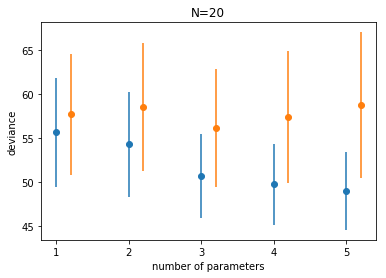

In [13]:
plt.plot(df.index, df.train, 'o', color = colors[0])
plt.errorbar(df.index, df.train, yerr=df.train_std, fmt=None, color=colors[0])
plt.plot(df.index+0.2, df.test, 'o', color = colors[1])
plt.errorbar(df.index+0.2, df.test, yerr=df.test_std, fmt=None, color=colors[1])
plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title("N=20");

Notice:

- the best fit model may not be the original generating model. Remember that the choice of fit depends on the amount of data you have and the less data you have, the less parameters you should use
- on average, out of sample deviance must be larger than in-sample deviance, through an individual pair may have that order reversed because of sample peculiarity.

## AIC, or the difference in deviances

Let us see the difference between the mean testing and training deviances. This is the difference in *bias* between the two sets.

In [14]:
df.test - df.train

1    2.018779
2    4.212654
3    5.441971
4    7.670368
5    9.691897
dtype: float64

Voila, this seems to be roughly twice the number of parameters. In other words we might be able to get away without a test set if we "correct" the bias on the traing set by $2n_p$. This is the observation that motivates the AIC.

### Analysis N=100

In [ ]:
reps=10000
results_100 = {}
for k in range(1,6):
    trdevs=np.zeros(reps)
    tedevs=np.zeros(reps)
    for r in range(reps):
        Xtr, ytr, Xte, yte = generate_data(100, k)
        ols = sm.OLS(ytr, Xtr).fit()
        mutr = np.dot(Xtr, ols.params)
        devtr = -2*np.sum(norm.logpdf(ytr, mutr, 1))
        mute = np.dot(Xte, ols.params)
        devte = -2*np.sum(norm.logpdf(yte, mute, 1))
        #print(k, r, devtr, devte)
        trdevs[r] = devtr
        tedevs[r] = devte
    results_100[k] = (np.mean(trdevs), np.std(trdevs), np.mean(tedevs), np.std(tedevs))

In [ ]:
df100 = pd.DataFrame(results_100).T
df100 = df100.rename(columns = dict(zip(range(4), ['train', 'train_std', 'test', 'test_std'])))
df100

In [ ]:
plt.plot(df100.index, df100.train, 'o', color = colors[0])
plt.errorbar(df100.index, df100.train, yerr=df100.train_std, fmt=None, color=colors[0])
plt.plot(df100.index+0.2, df100.test, 'o', color = colors[1])
plt.errorbar(df100.index+0.2, df100.test, yerr=df100.test_std, fmt=None, color=colors[1])
plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title("N=100");

In [234]:
df100.test - df100.train

1    1.900383
2    3.908291
3    5.193728
4    7.003606
5    8.649499
dtype: float64

We get pretty much the same result at N=100.

## Assumptions for AIC

This observation leads to an estimate of the out-of-sample deviance by what is called an **information criterion**, the Akaike Information Criterion, or AIC:

$$AIC = D_{train} + 2n_p$$

which does carry as assumptions that

1. the likelihood is approximately multivariate gaussian
2. the sample size is much larger than the number of parameters
3. priors are flat 
4. The AIC does not assume that the true data generating process $p$ is in the set of models being fitted. The overarching goal of the AIC approach to model selection is to select the "best" model for our given data set without assuming that the "true" model is in the family of models from which we're selecting. The true model "cancels out" except in the expectation.

We wont derive the AIC here, but if you are interested, see  http://www.stat.cmu.edu/~larry/=stat705/Lecture16.pdf

Why would we want to use such information criteria? Cross validation can be expensive, especially with multiple hyper-parameters.

## AIC for Linear Regression

The AIC for a model is the training deviance plus twice the number of parameters:

$$AIC = D_{train} + 2n_p.$$

That is, -2 times the log likelihood of the model.

So, one we find the MLE solution for the linear regression, we plugin the values we get, which are

$$\sigma_{MLE}^2 =  \frac{1}{N} RSS $$

where RSS is the sum of the  squares of the errors.

$$AIC = -2(-\frac{N}{2}(log(2\pi) + log(\sigma^2)) -2(-\frac{1}{2\sigma_{MLE}^2} \times RSS) + 2p$$

Thus:

$$D = Nlog(RSS/N) $$

$$AIC = Nlog(RSS/N) + 2p + constant$$

Since the deviance for a OLS model is just proportional to the log(MSE) upto a proportionality, we'll use the MSE to derive this split.

The fact that the (log-likelihood) and thus the deviance  carries an expectation over the true distribution as estimated on the sample means that the **Deviance is a stochastic quantity, varying from sample to sample**.

## A complete understanding of the comparison diagram

(taken from McElreath, but see upstairs as well)

![](images/inoutdeviance.png)

Now we are equipped to understand this diagram completely. Lets focus on the training (in) set first: blue points. 

1. There is some irreducible noise which contributes to the deviance no matter the number of parameters.
2. If we could capture the true model exactly there would be no **bias**, and the deviance would go to that which comes from the irreducible noise.
3. But we cant, so the positions of the circles tells us how much bias plus irreducible noise we have
4. The error bars now tell us our **variance**, since they tell us how much our deviance, or MSE varies around our "mean" model. In real life our sample will lie somewhere along this error bar.
5. The training set deviances go down as the number of parameters increase. The test set deviances go down and then go up
6. Notice that testing deviance is higher on a 2 parameter model than on a 1, even though our generating "true" model is a 2 parameter one. Deviance and the AIC do not pick the true model, but rather the one with the highest predictive accuracy.